In [292]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Read the raw file with results to a data frame

In [459]:
df = pd.read_csv("data/PART2_withoutDuplicatedHeaders.csv", sep = ';')

Drop the first row as it was just a test run

In [460]:
df = df[~df.index.isin([1])]

Split the name column so that comma separted values are placed in separate columns.
Then, delete all the measurements that have prod rate 100k, as it turned out to not influence the results

In [461]:
# check how many distinct values are in the string
name_col_components = ["ack_batch", "parti", "rate"]
df[name_col_components] = df["name"].str.split(',', expand=True)

In [462]:
df = df.loc[df["rate"]=="rate=50000"]

In [463]:
number_of_measures_rates = len(df["producerRates"].loc[0].split(','))
rates_indeces = ["rm{}".format(i+1) for i in range(0, number_of_measures_rates)]
thro_indeces = ["tm{}".format(i+1) for i in range(0, number_of_measures_rates)]

In [464]:
df['failedMessages'].isna().values.any()

False

In [465]:
df.drop(columns=["name", "failedMessages", 'lingerMs', 'recSizeMax', 'recSizeAvg', 'ack_batch', "batchSizeMax",
                 "benchTime", "recQueTimeAvg", "recQueTimeMax", "recSendTotal"], inplace=True)

In [466]:
def percentage_change(col1,col2):
    return (col2 / col1) * 100

In [467]:
df['batchesRation'] = percentage_change(df['batchSize'],df['batchSizeAvg'])

In [468]:
df[rates_indeces] = df["producerRates"].str.split(',', expand=True)
df[thro_indeces] = df["producerThroughputs"].str.split(',', expand=True)
df.drop(columns=['producerThroughputs', 'producerRates'], inplace=True)

In [469]:
df[rates_indeces] = df[rates_indeces].astype(float)
df[thro_indeces] = df[thro_indeces].astype(float)

In [470]:
df["rate_min"] = df[rates_indeces].min(axis=1)
df["rate_max"] = df[rates_indeces].max(axis=1)
df["rate_avg"] = df[rates_indeces].mean(axis=1)

df["thro_min"] = df[thro_indeces].min(axis=1)
df["thro_max"] = df[thro_indeces].max(axis=1)
df["thro_avg"] = df[thro_indeces].mean(axis=1)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram')

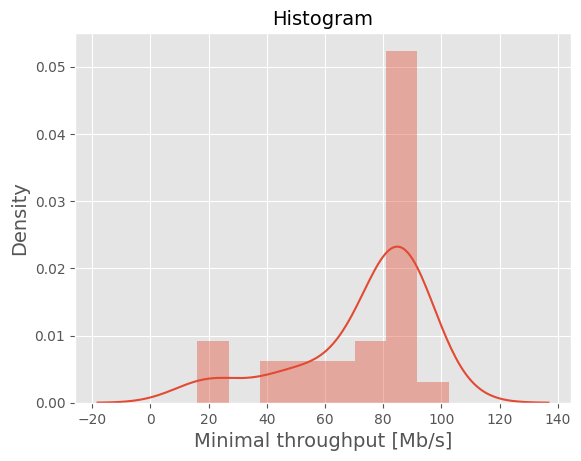

In [471]:
dp = sns.distplot(df["thro_min"])
#bp = sns.boxplot(data=data)
dp.set_xlabel("Minimal throughput [Mb/s]", fontsize=14)
dp.set_ylabel("Density", fontsize=14)
dp.axes.set_title("Histogram", fontsize=14)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram')

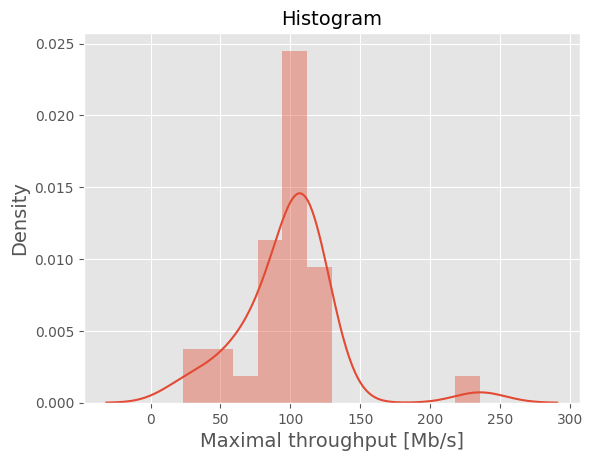

In [472]:
dp = sns.distplot(df["thro_max"])
#bp = sns.boxplot(data=data)
dp.set_xlabel("Maximal throughput [Mb/s]", fontsize=14)
dp.set_ylabel("Density", fontsize=14)
dp.axes.set_title("Histogram", fontsize=14)

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='thro_avg', ylabel='Density'>

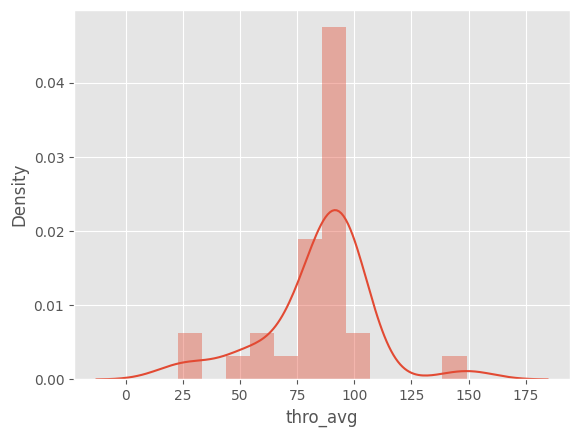

In [473]:
sns.distplot(df["thro_avg"])

# Acks analysis

In [474]:
columns_for_acks_analysis =  ["acks", "thro_min", "thro_max", "thro_avg"] + thro_indeces
acks_df = df[columns_for_acks_analysis]
acks_group_by = acks_df.groupby("acks")[thro_indeces].mean()
acks_group_by["group_name"] = ["0", "1", "all"]

In [475]:
def plot_of(data, column_accessor, title, xlabel="Measurement", ylabel="Throughput [MB/s]"):
    plt.rcParams.update(plt.rcParamsDefault)
    plt.style.use("ggplot")
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks(np.arange(1,21,1))
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    counter = 0
    for index, row in data.iterrows():
        ax.plot(np.arange(1, 21), row[column_accessor], color=find_color(counter), label=row["group_name"])
        counter += 1
    plt.legend()
    plt.show()

def find_color(counter, first_color_map_name="Dark2", second_color_map_name="Accent"):

    first_color_map = plt.get_cmap(first_color_map_name).colors
    second_color_map = plt.get_cmap(second_color_map_name).colors

    if counter < len(first_color_map):
        return first_color_map[counter]
    else:
        counter = counter % len(first_color_map)
        return second_color_map[counter]

def box_plot_of(data, x_label, y_label, title):
    plt.figure(figsize=(24,12))
    bp = sns.boxplot(data=data)
    bp.set_xlabel(x_label, fontsize=20)
    bp.set_ylabel(y_label, fontsize=20)
    bp.axes.set_title(title, fontsize=20)
    plt.xticks(rotation=90)
    plt.show()

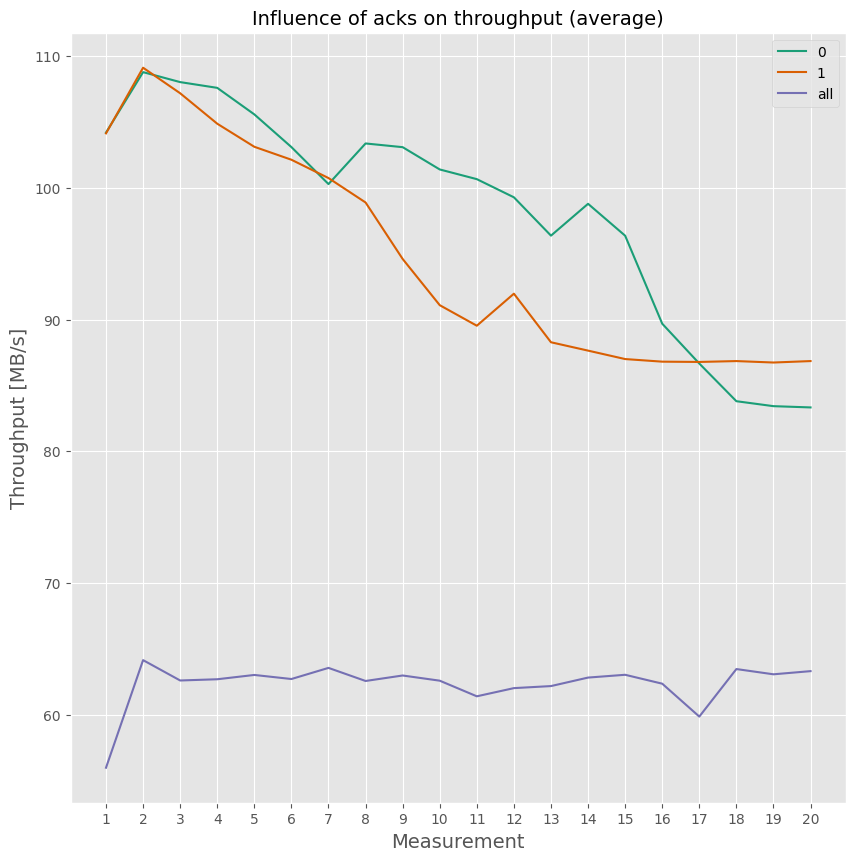

In [476]:
plot_of(acks_group_by, thro_indeces, "Influence of acks on throughput (average)")

In [477]:
ack0 = acks_df[(acks_df["acks"]=="0")]
ack1 = acks_df[(acks_df["acks"]=="1")]
ackA = acks_df[(acks_df["acks"]=="all")]

ack0 = ack0.loc[:, ~ack0.columns.isin(["thro_avg", "thro_max", 'thro_min'])]
ack1 = ack1.loc[:, ~ack1.columns.isin(["thro_avg", "thro_max", 'thro_min'])]
ackA = ackA.loc[:, ~ackA.columns.isin(["thro_avg", "thro_max", 'thro_min'])]

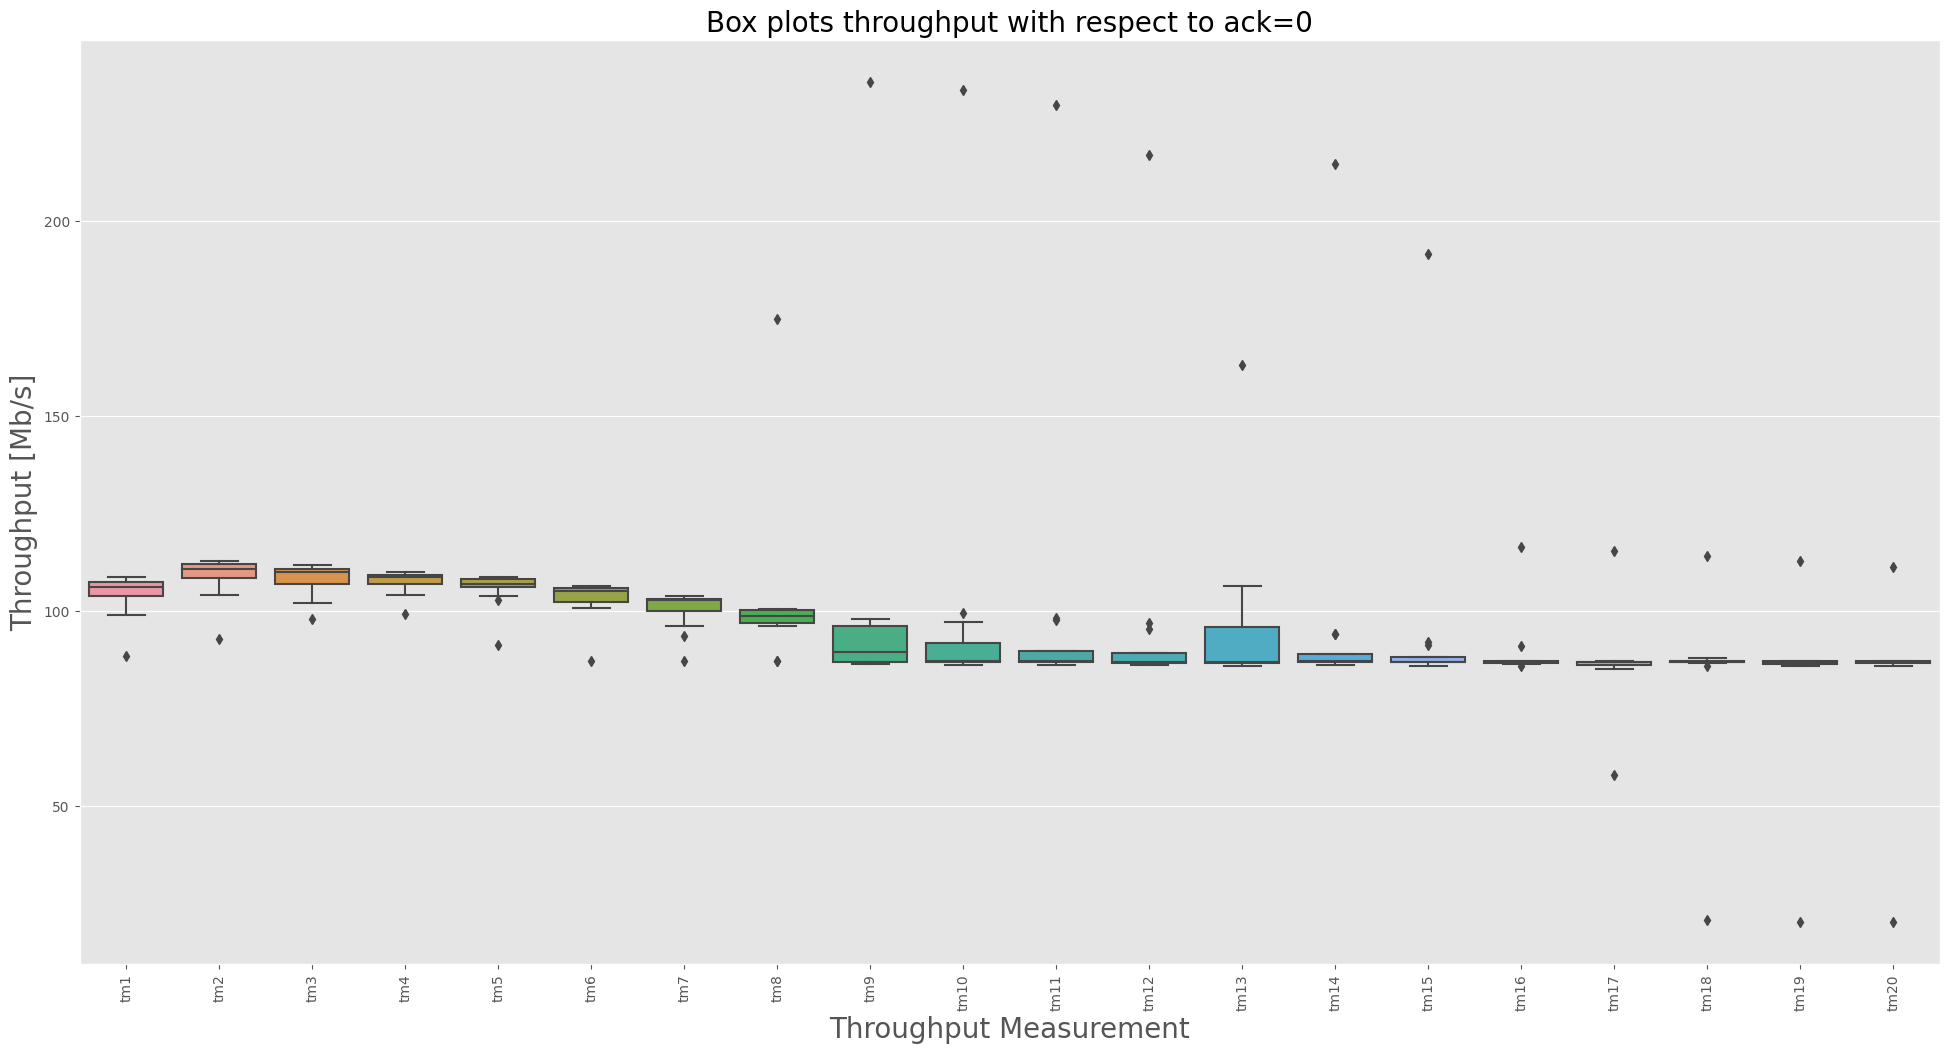

In [478]:
box_plot_of(ack0, "Throughput Measurement", "Throughput [Mb/s]", 'Box plots throughput with respect to ack=0')

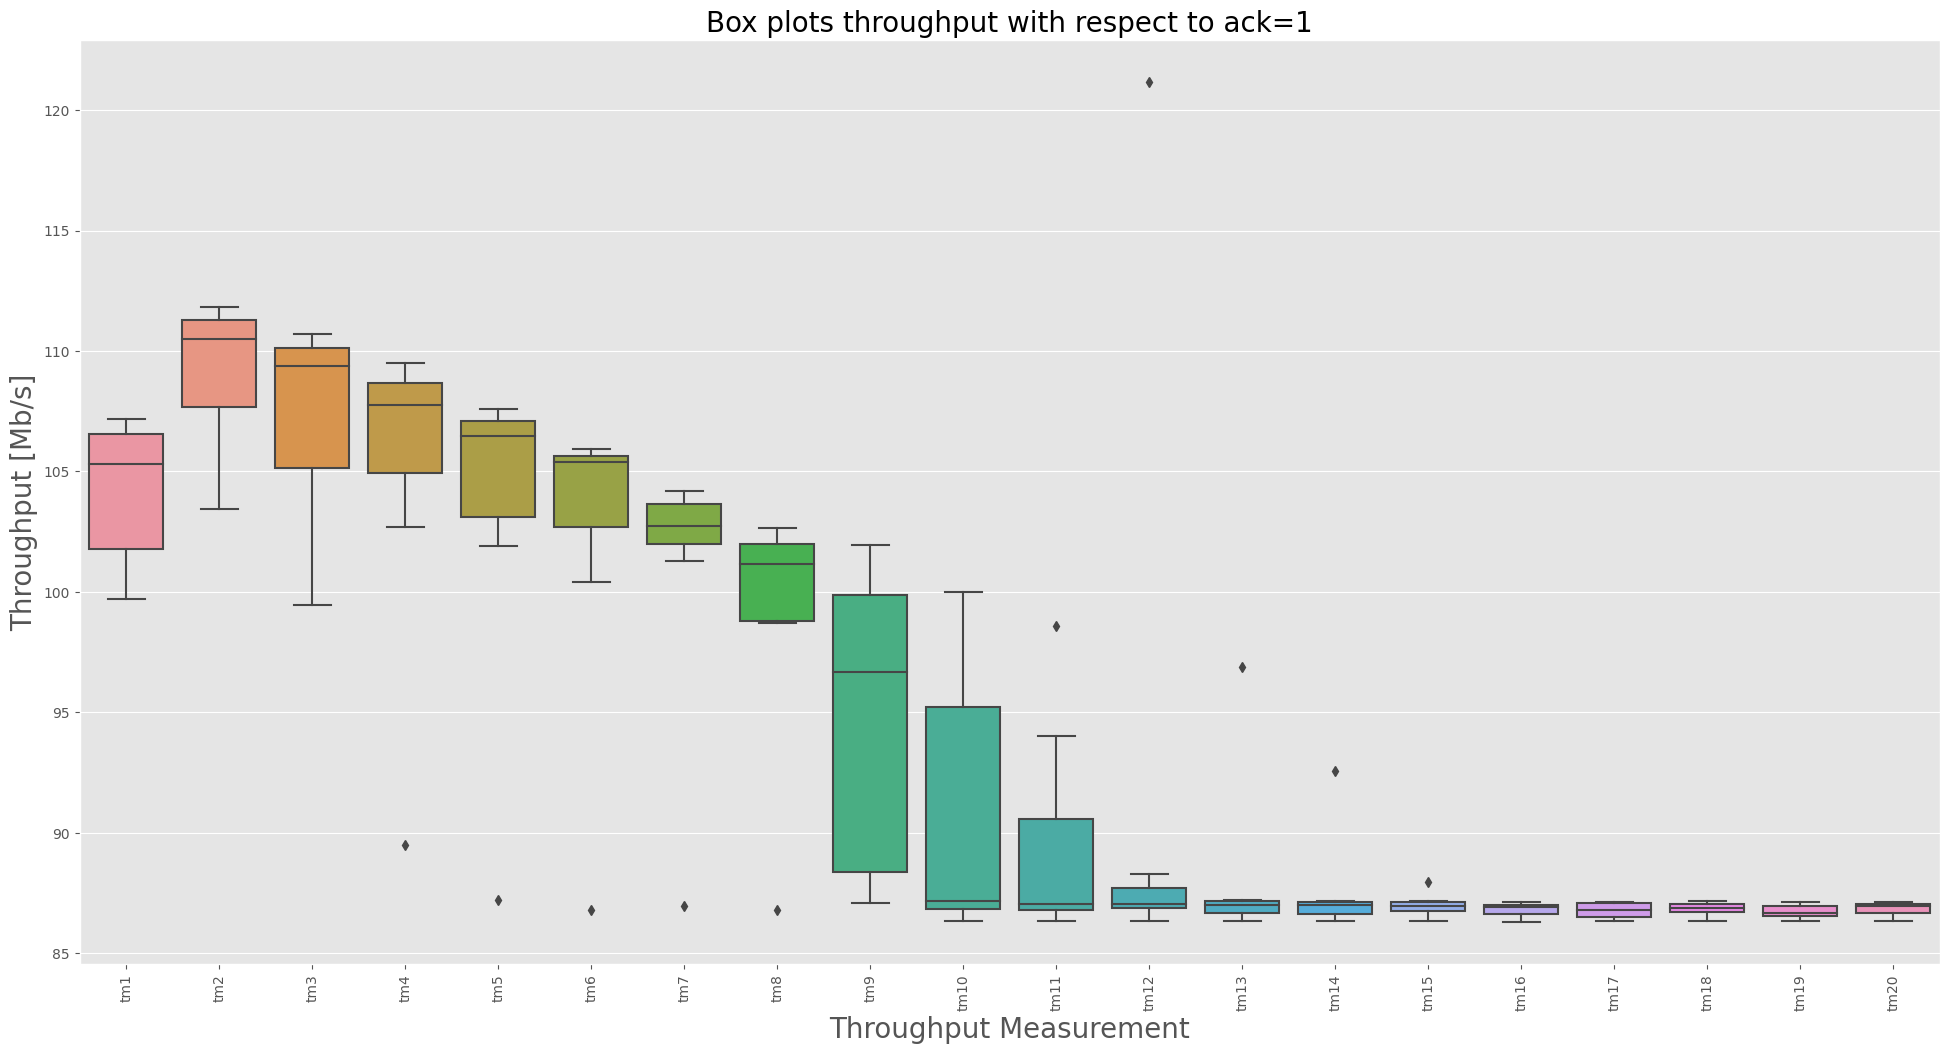

In [479]:
box_plot_of(ack1, "Throughput Measurement", "Throughput [Mb/s]", 'Box plots throughput with respect to ack=1')

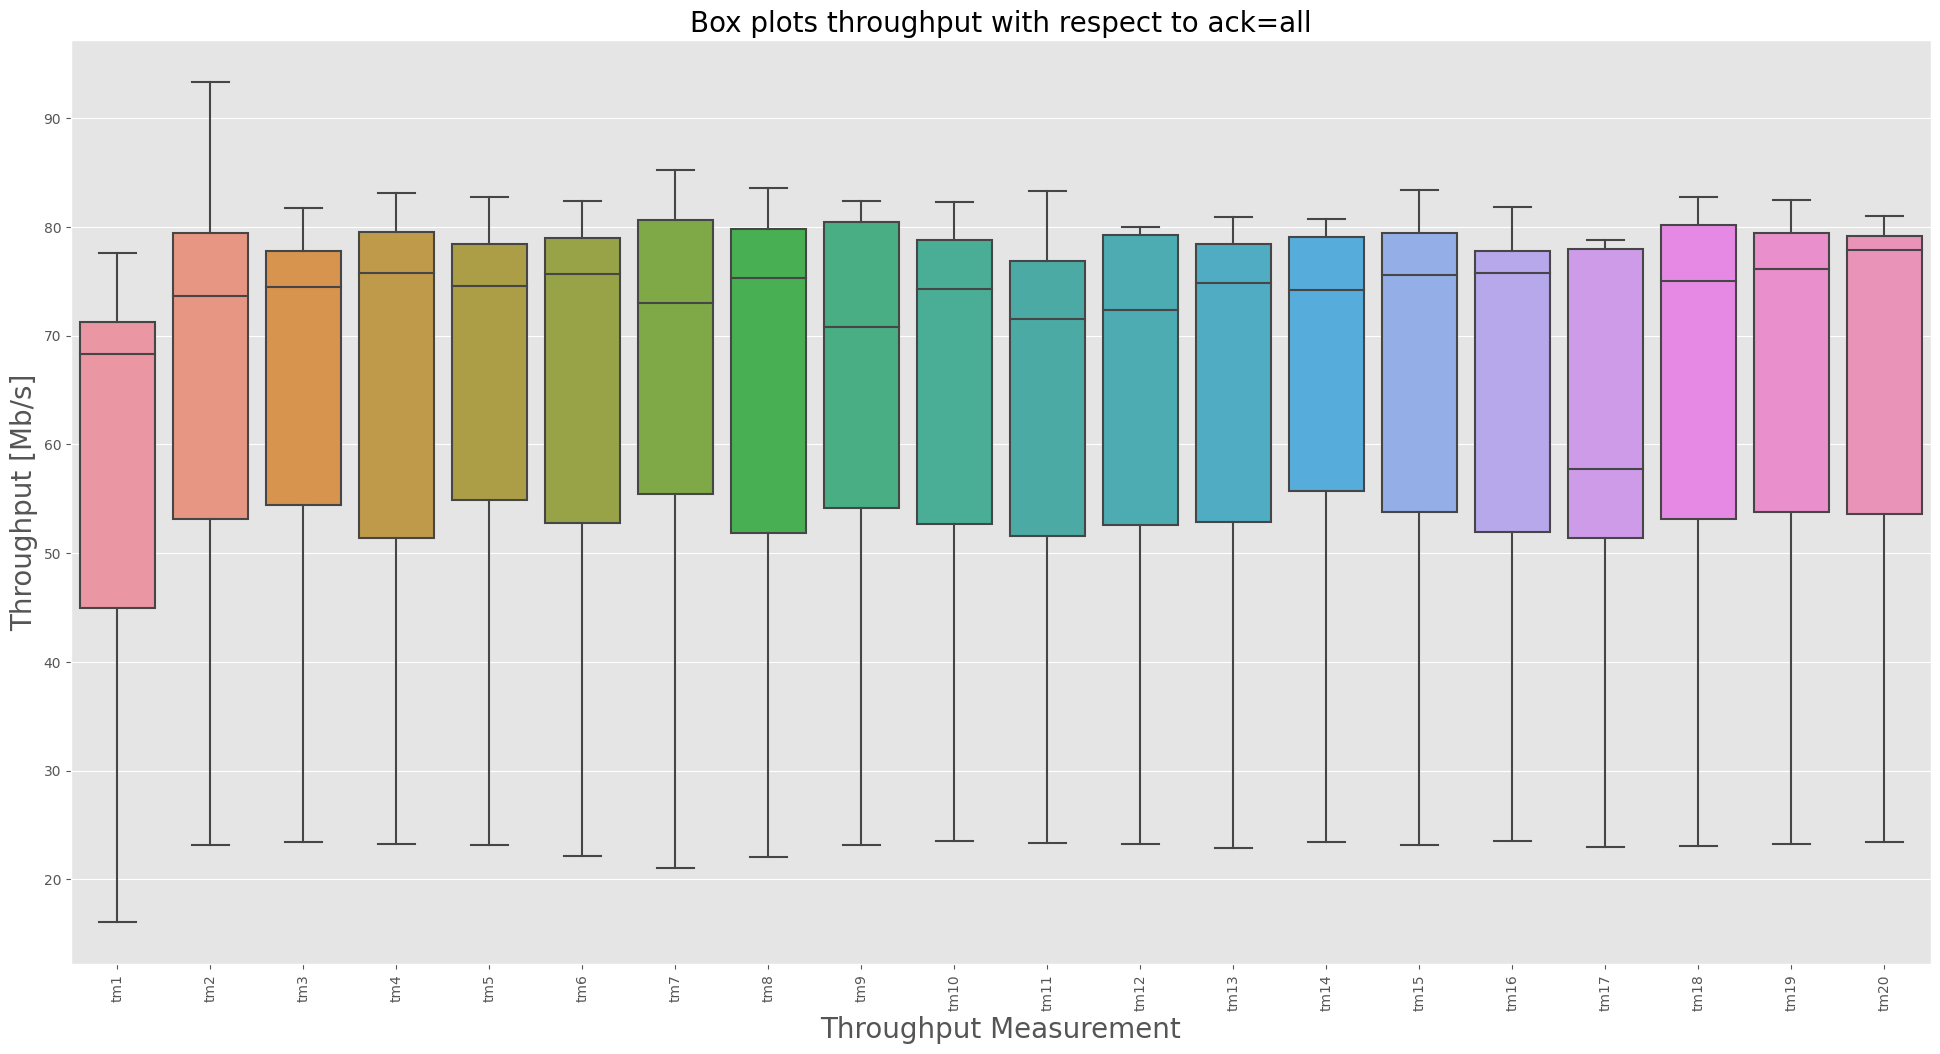

In [480]:
box_plot_of(ackA, "Throughput Measurement", "Throughput [Mb/s]", 'Box plots throughput with respect to ack=all')

# Batch size analysis

In [481]:
columns_for_batch_analysis = thro_indeces + ["batchSize", "thro_min", "thro_max", "thro_avg"]
batch_df = df[columns_for_batch_analysis]
batch_group_by = batch_df.groupby("batchSize")[thro_indeces].mean()
batch_group_by["group_name"] = [16384, 32768, 131072, 262144, 524288]

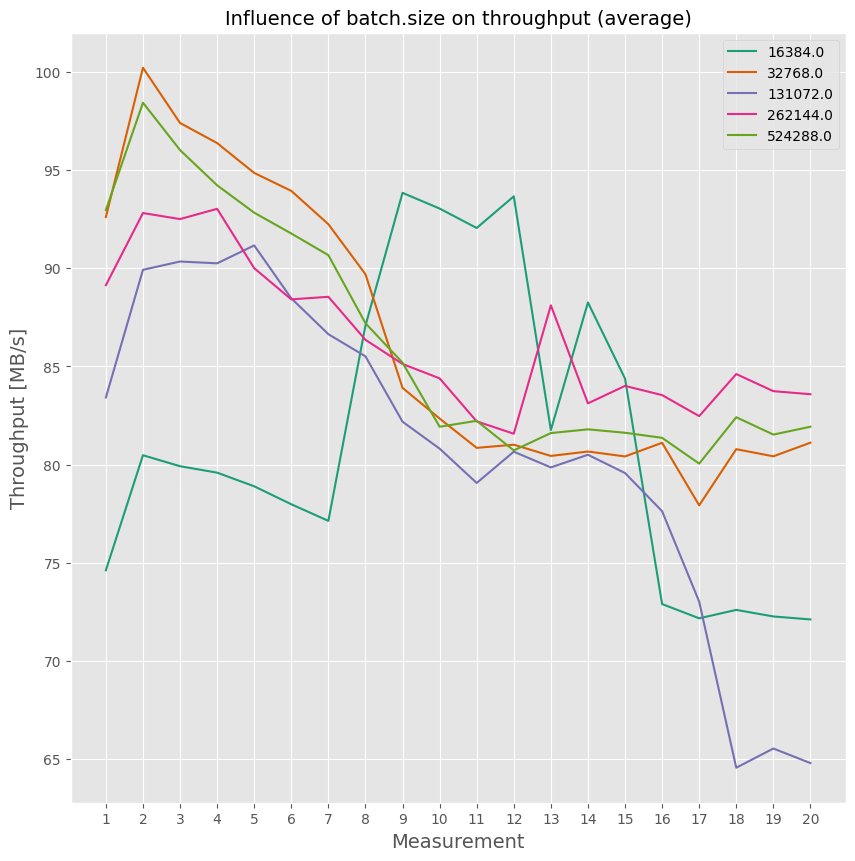

In [482]:
plot_of(batch_group_by, thro_indeces, "Influence of batch.size on throughput (average)")

In [483]:
b16 = batch_df[(batch_df["batchSize"]==16384)]
b32 = batch_df[(batch_df["batchSize"]==32768)]
b130 = batch_df[(batch_df["batchSize"]==131072)]
b262 = batch_df[(batch_df["batchSize"]==262144)]
b524 = batch_df[(batch_df["batchSize"]==524288)]

b16 = b16.loc[:, ~b16.columns.isin(["thro_avg", "thro_max", 'thro_min', 'batchSize'])]
b32 = b32.loc[:, ~b32.columns.isin(["thro_avg", "thro_max", 'thro_min', 'batchSize'])]
b130 = b130.loc[:, ~b130.columns.isin(["thro_avg", "thro_max", 'thro_min', 'batchSize'])]
b262 = b262.loc[:, ~b262.columns.isin(["thro_avg", "thro_max", 'thro_min', 'batchSize'])]
b524 = b524.loc[:, ~b524.columns.isin(["thro_avg", "thro_max", 'thro_min', 'batchSize'])]

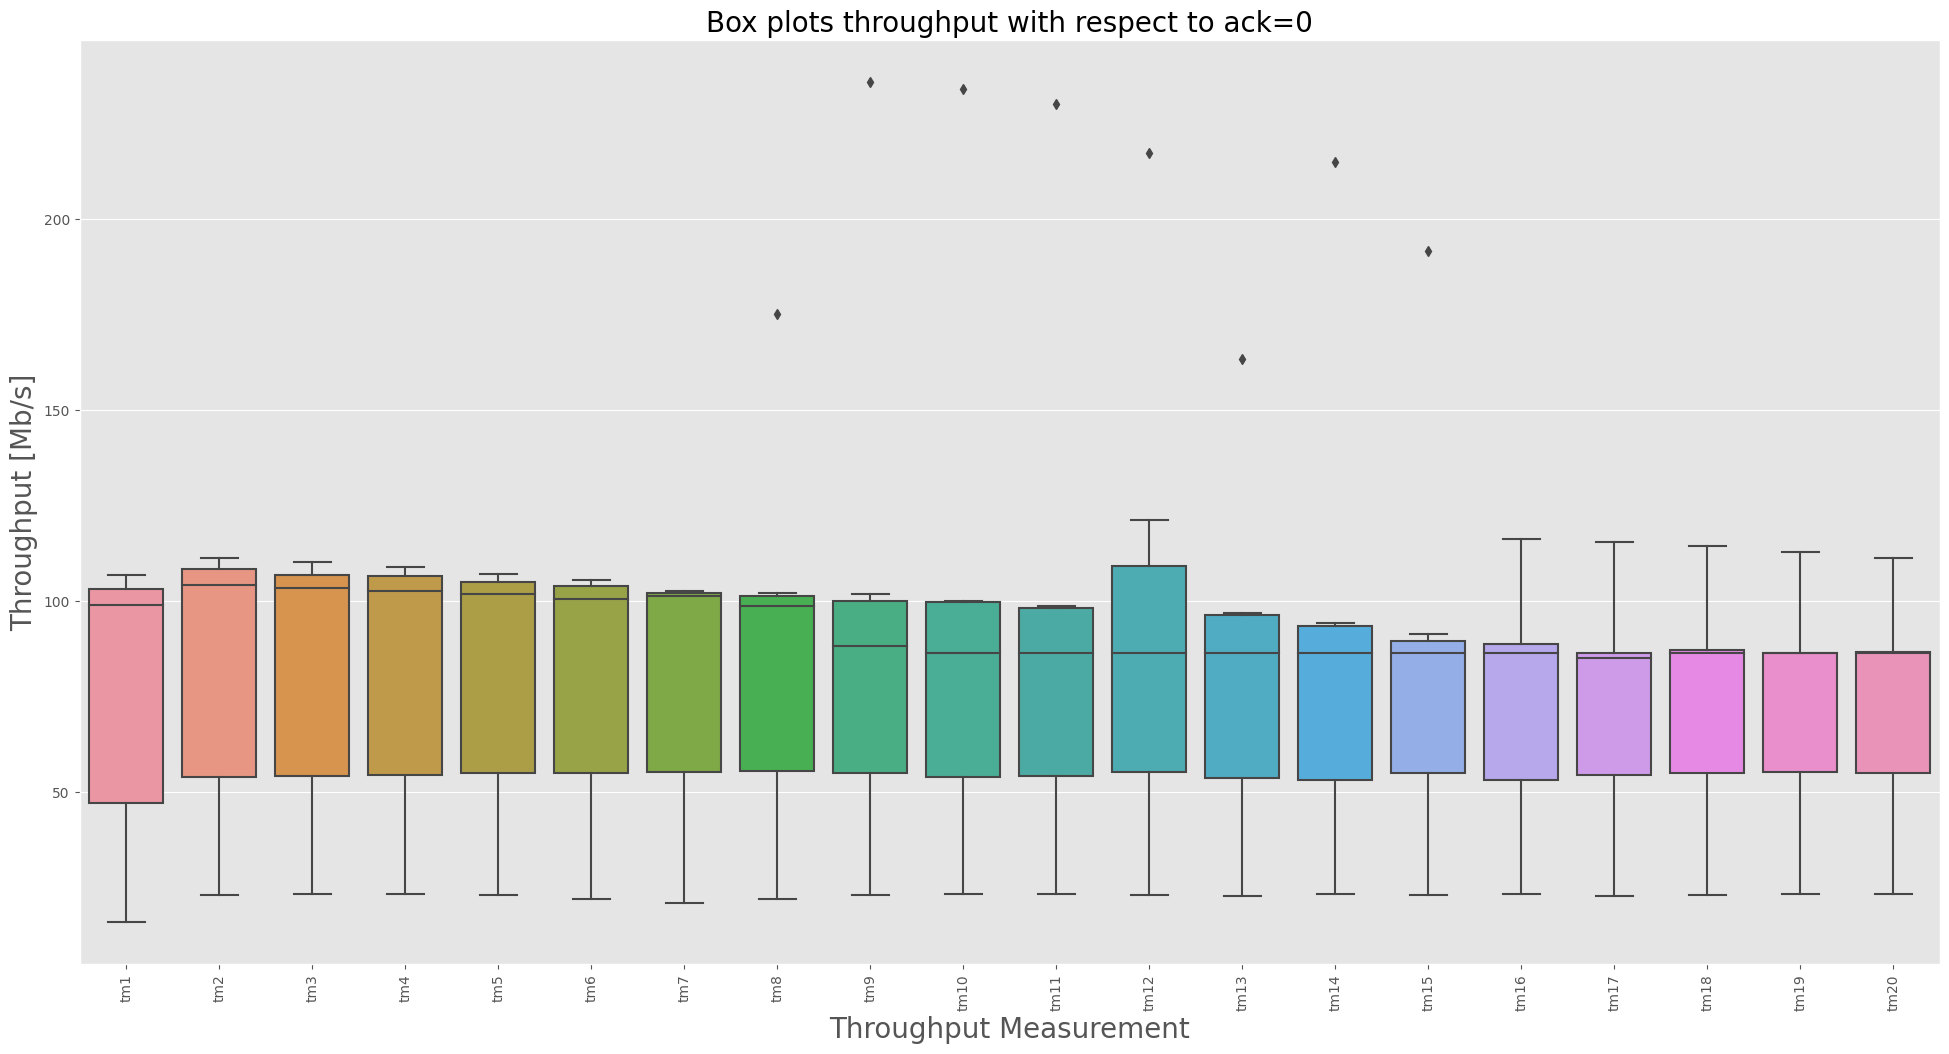

In [484]:
box_plot_of(b16, "Throughput Measurement", "Throughput [Mb/s]", 'Box plots throughput with respect to ack=0')

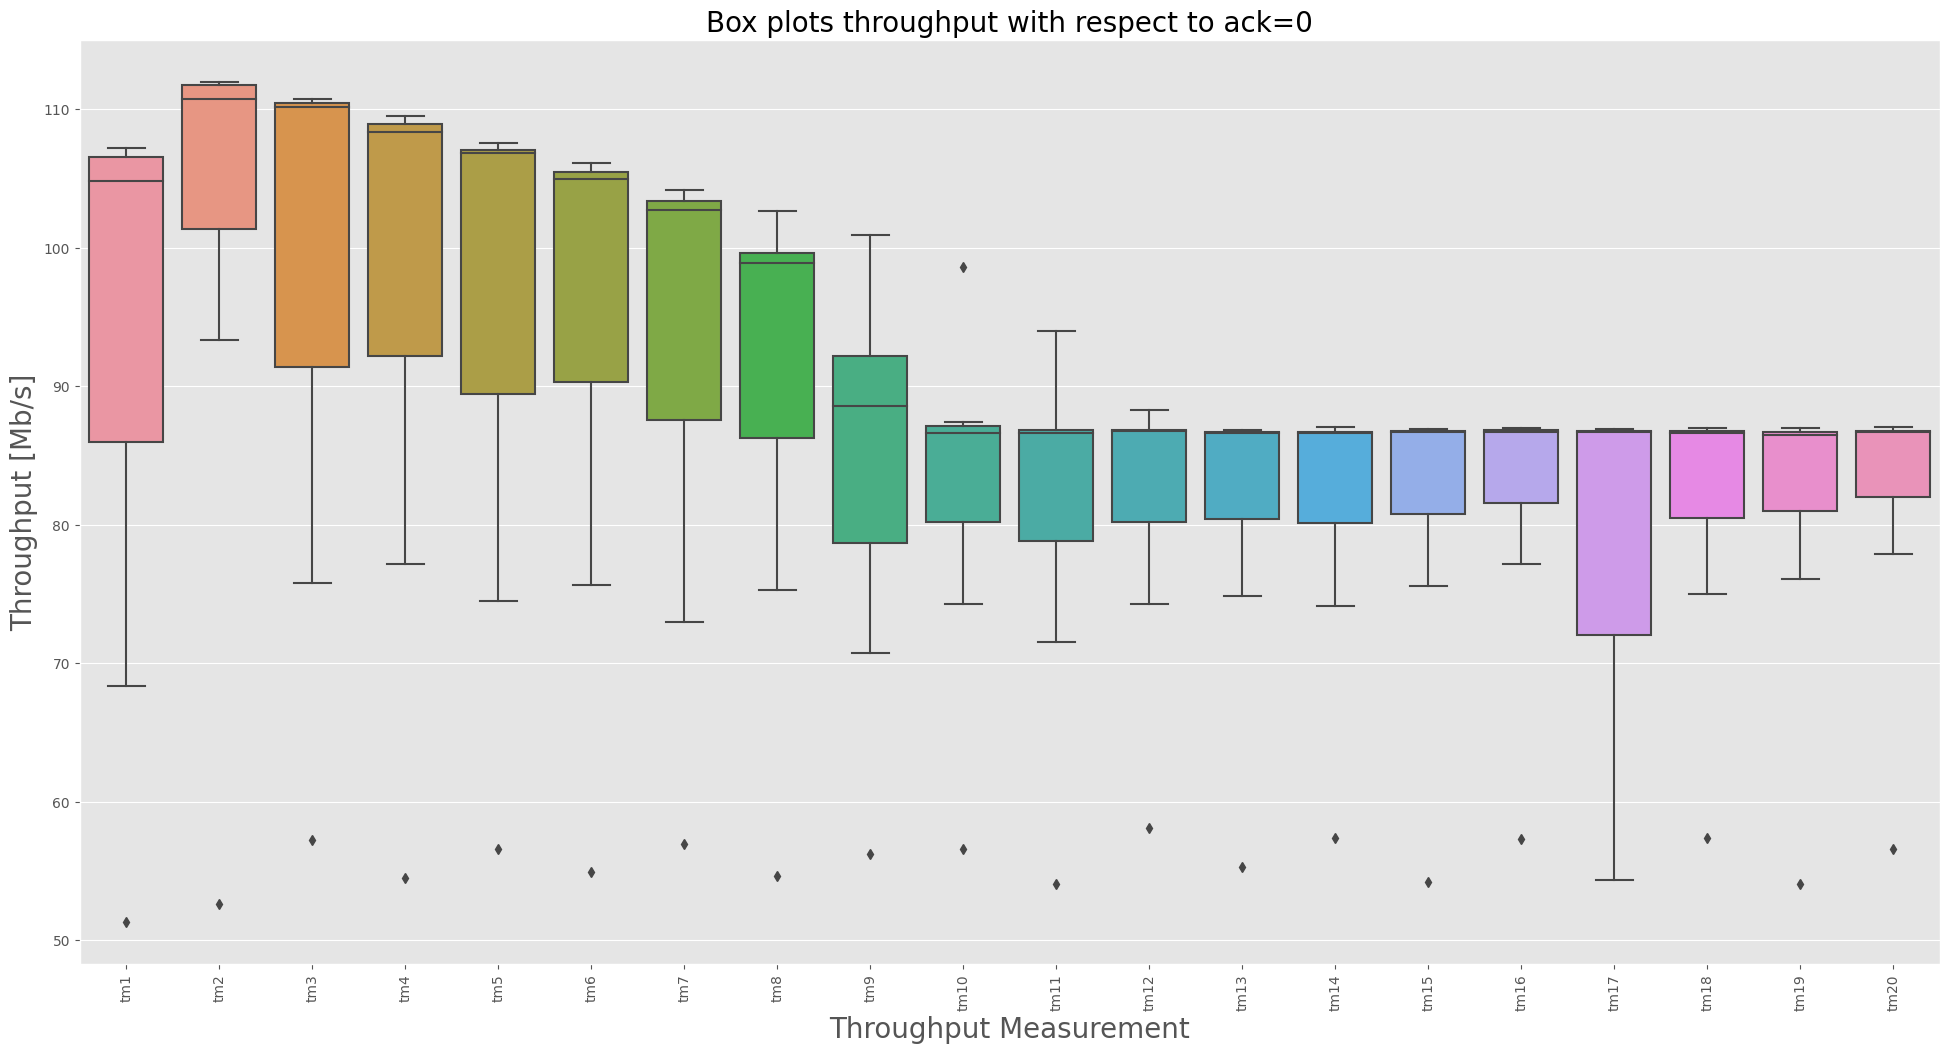

In [485]:
box_plot_of(b32, "Throughput Measurement", "Throughput [Mb/s]", 'Box plots throughput with respect to ack=0')

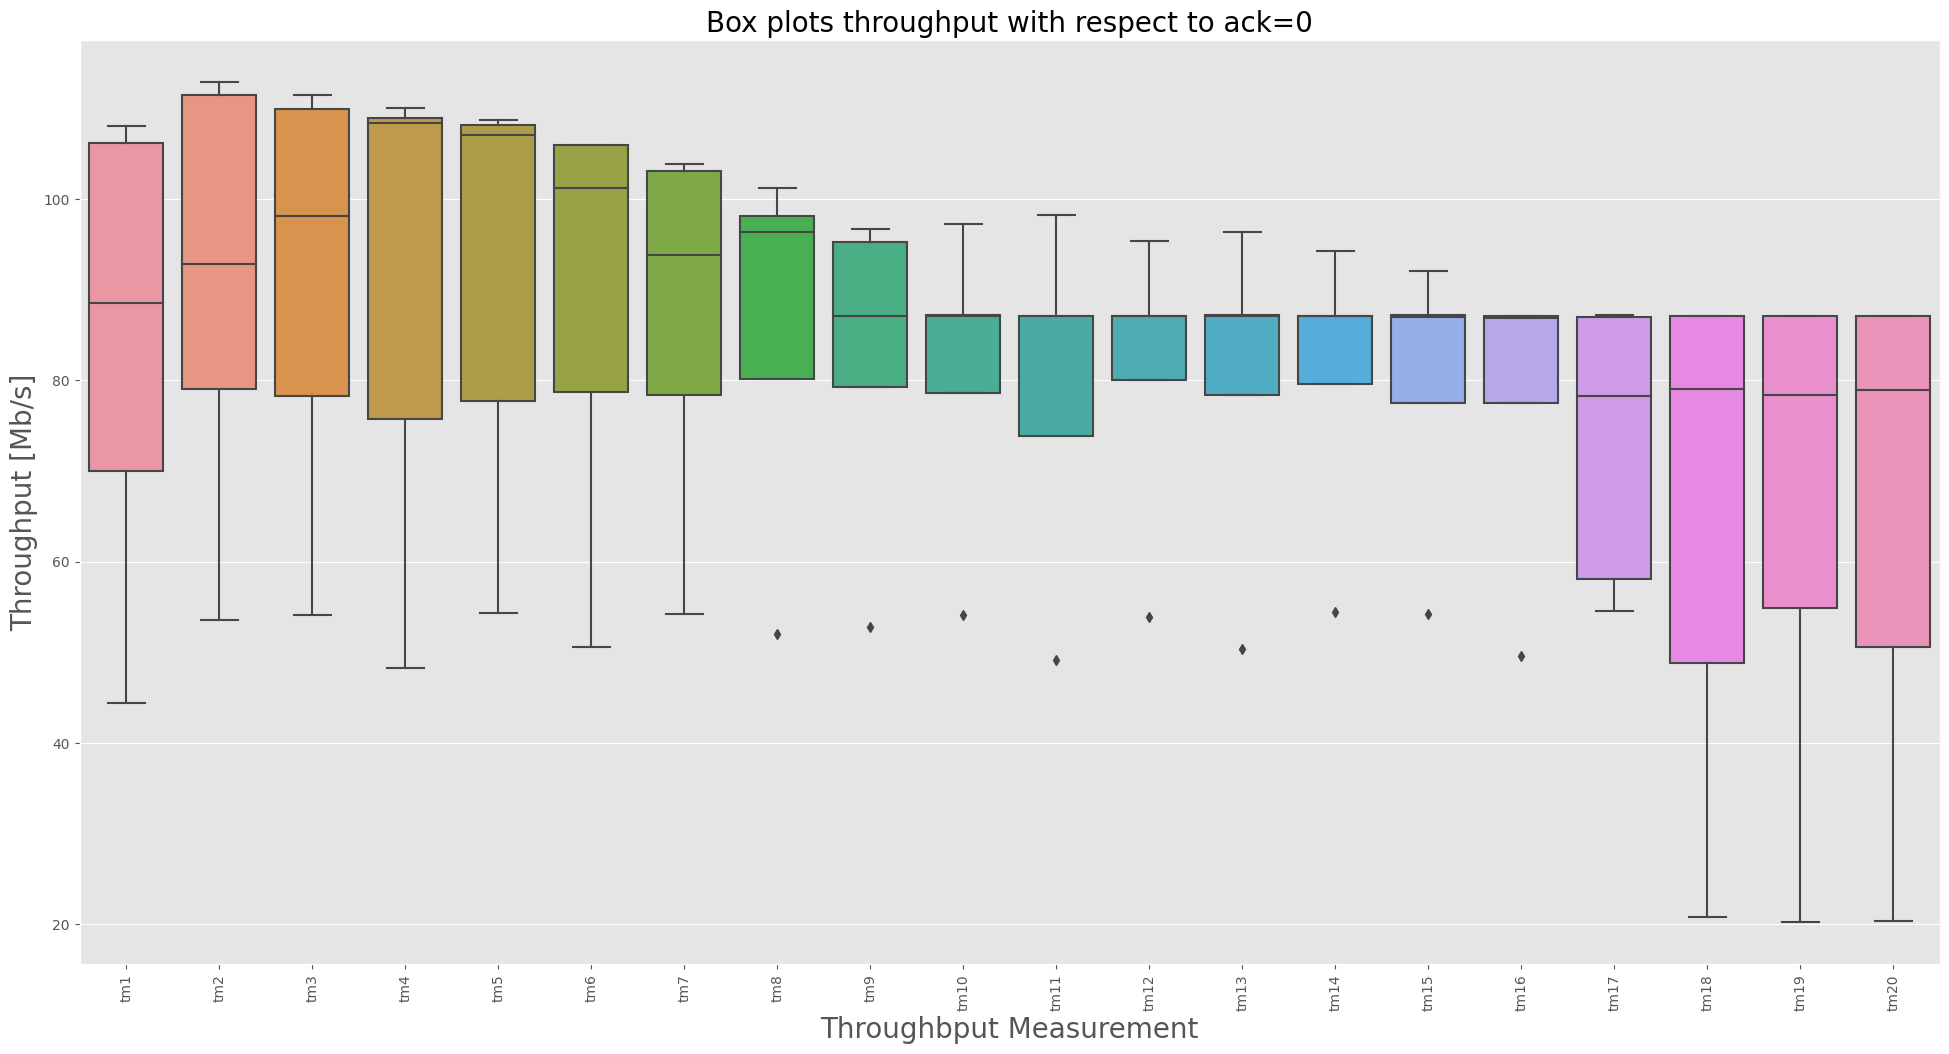

In [486]:
box_plot_of(b130, "Throughbput Measurement", "Throughput [Mb/s]", 'Box plots throughput with respect to ack=0')

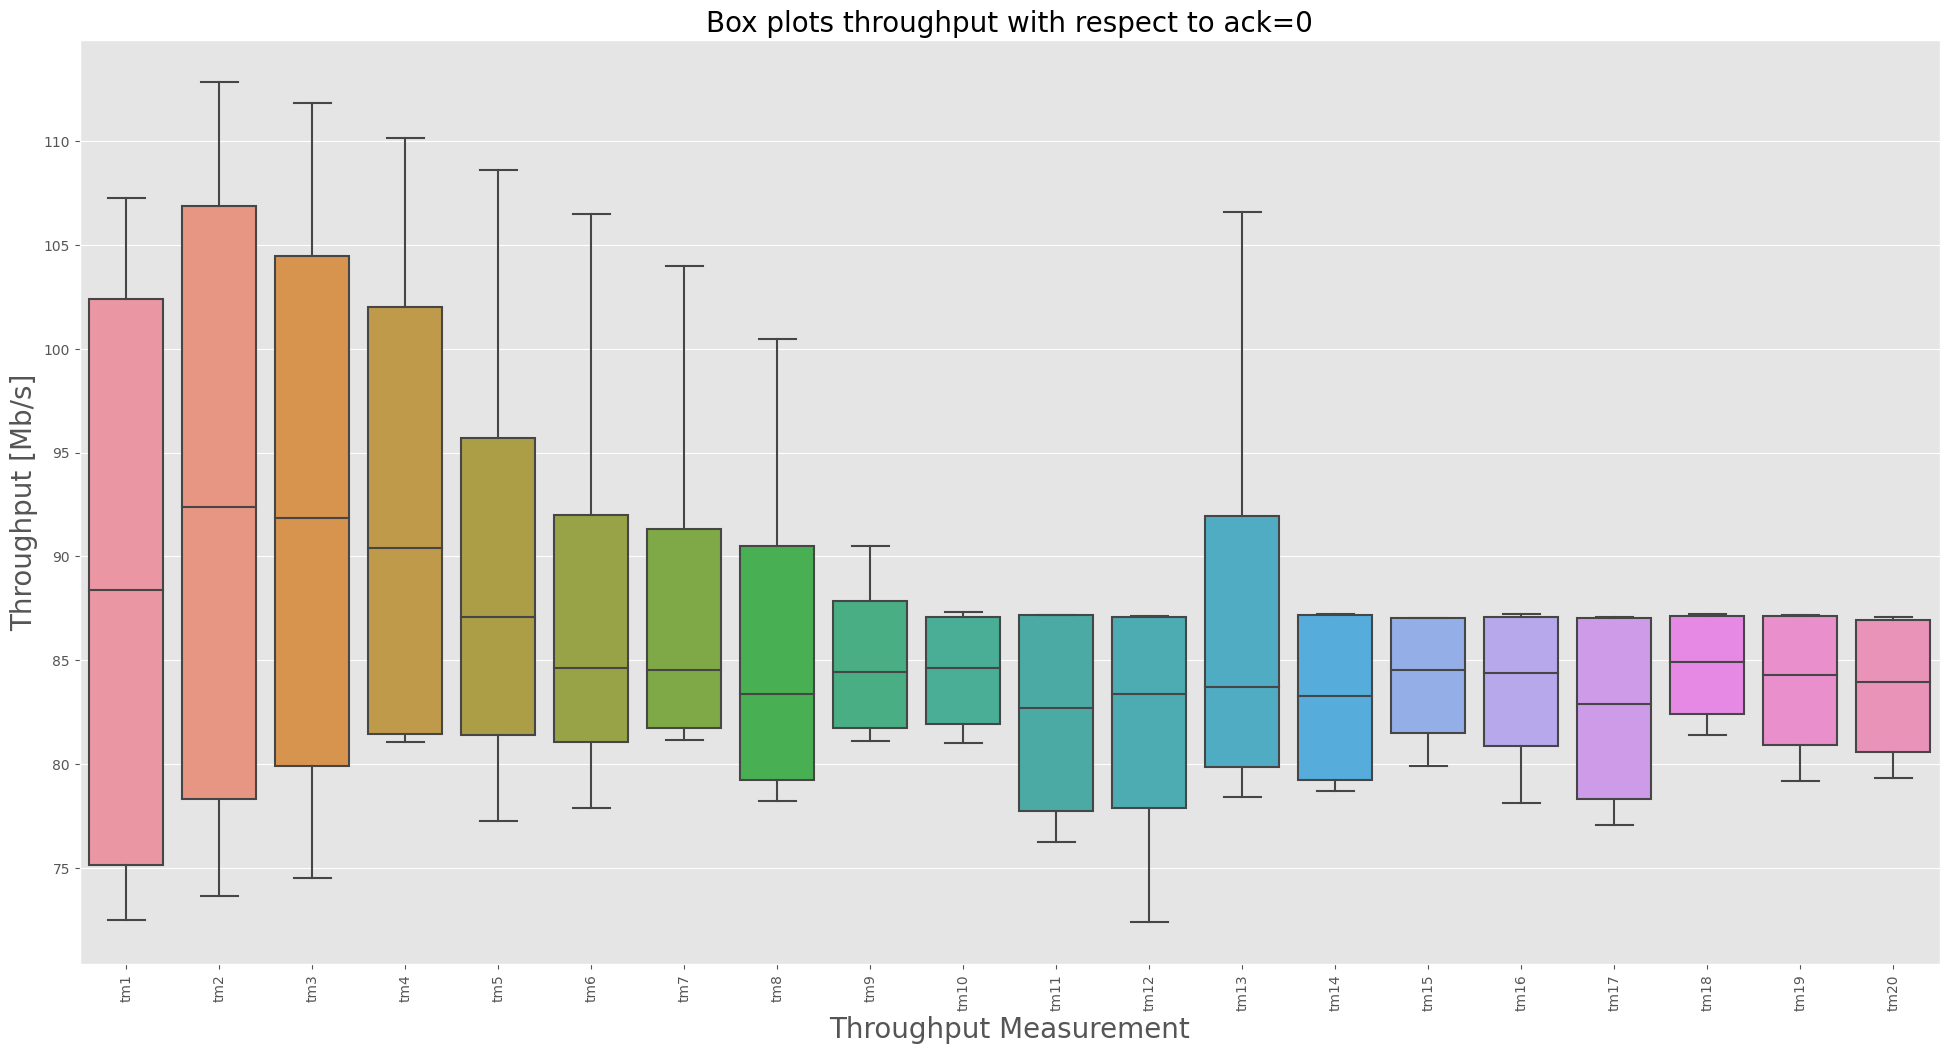

In [487]:
box_plot_of(b262, "Throughput Measurement", "Throughput [Mb/s]", 'Box plots throughput with respect to ack=0')

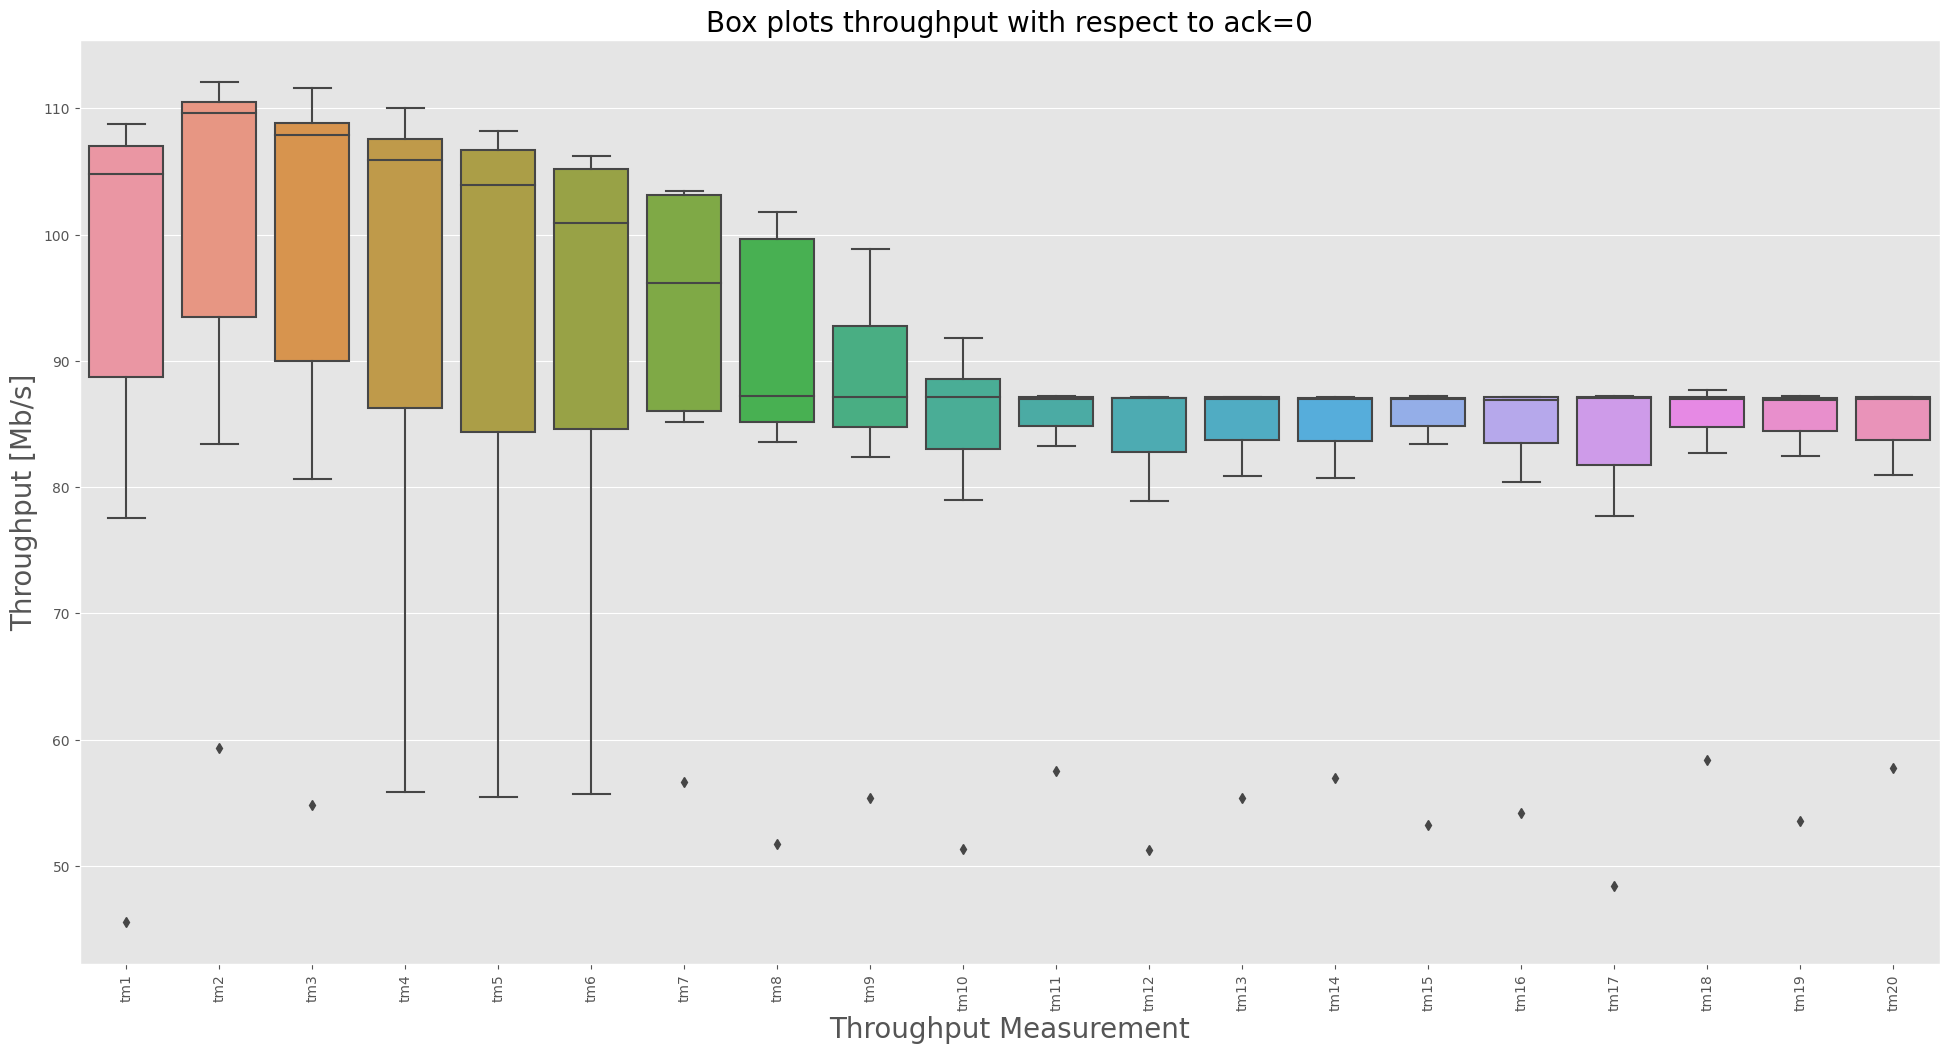

In [488]:
box_plot_of(b524, "Throughput Measurement", "Throughput [Mb/s]", 'Box plots throughput with respect to ack=0')

additional batch size impact analysis for ack 0 and 1

(-0.5, 4.5, 50.0, 150.0)

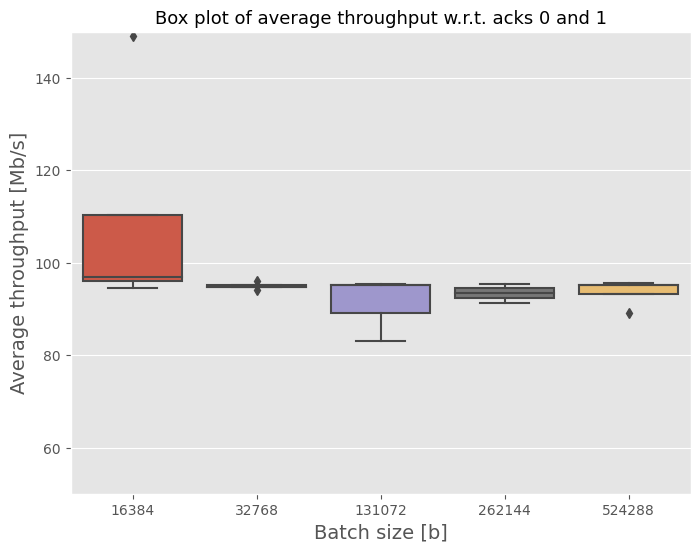

In [489]:
df_ = df[df.acks.isin(["0", "1"])]
var = 'batchSize'
data = pd.concat([df_['thro_avg'], df_[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="thro_avg", data=data)
fig.set_xlabel("Batch size [b]", fontsize=14)
fig.set_ylabel("Average throughput [Mb/s]", fontsize=14)
fig.axes.set_title("Box plot of average throughput w.r.t. acks 0 and 1", fontsize=13)

fig.axis(ymin=50, ymax=150)


# Partition analysis

In [490]:
df_ = df[df.acks.isin(["0", "1"])]
columns_for_part_analysis = thro_indeces + ["partitions", "thro_min", "thro_max", "thro_avg"]
part_df = df_[columns_for_part_analysis]
part_group_by = part_df.groupby("partitions")[thro_indeces].mean()
part_group_by["group_name"] = [1, 10, 100]

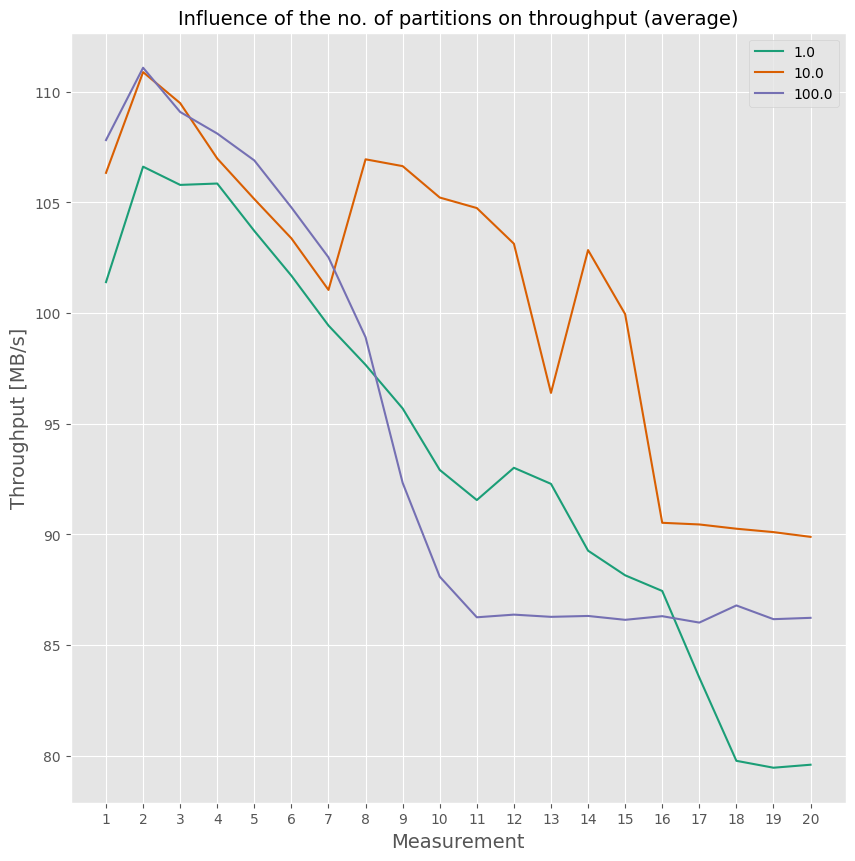

In [491]:
plot_of(part_group_by, thro_indeces, "Influence of the no. of partitions on throughput (average)")

Find config that gave the best throughput

In [150]:
# we're making sure that x is str
df["name"] = df[["acks", 'batchSize', 'partitions']].apply(lambda x: '_'.join(x.astype(str)), axis=1)

In [156]:
df[(df["acks"]=="0") & (df["batchSize"]==16384) & (df['partitions']==10)]

,acks,aveLatency,batchSize,batchSizeAvg,batchSizeMax,benchTime,maxLatency,partitions,publishRate,recPerReqAvg,...,prodThro17,prodThro18,prodThro19,rate_min,rate_max,rate_avg,thro_min,thro_max,thro_avg,name
26,0,550.71,16384,8816.72,15664.5,2022-02-04T17:48:51.839081,8408.25,10,0.3,23.53,...,114.28,112.84,111.37,105068.2,241423.57,152694.8545,102.61,235.77,149.1175,0_16384_10


Generate final file

In [492]:
def df_to_csv(df, file_name):
    """
    Save a dataframe into a csv file.
    """
    df.to_csv(file_name + ".csv", sep=";", index=False)

In [494]:
df_to_csv(df, "PART3_finalDataset")